In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [6]:
iggs = [1, 10]
linestyles = ['--', ':']

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, linestyle in zip(iggs, linestyles):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =2.22e-20

nband = 165

ng =4

ng_refs = (/ 2 , 2 /) 

nref =2

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 500 /) 

t_refs = (/ 250 , 250 /) 

tsfc =294

vstar = 1215

data w_diffuse
     &     /1.5 , 1.5 , 1.5 , 1.5/

data wgt
     &     /0.6 , 0.6 , 0.7 , 0.9/

atmosphere_profiles/mls75.pro


In [12]:
fig.display_hrefanchor()

In [13]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [14]:
table_dgdgs.display_hrefanchor()

In [15]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [16]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

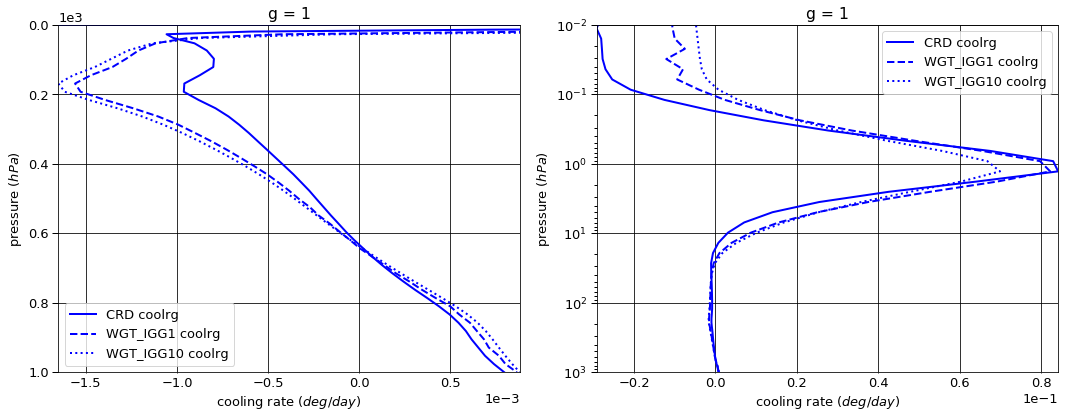

# Figure: cooling rate g-group 2

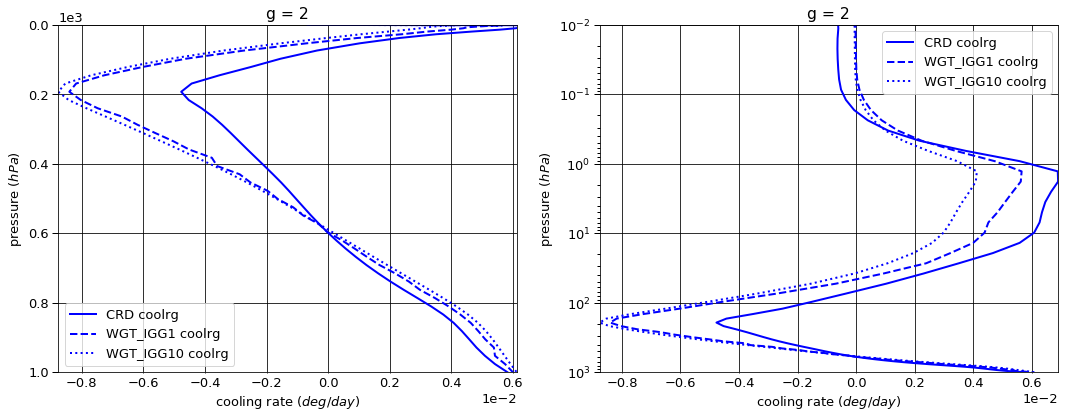

# Figure: cooling rate g-group 3

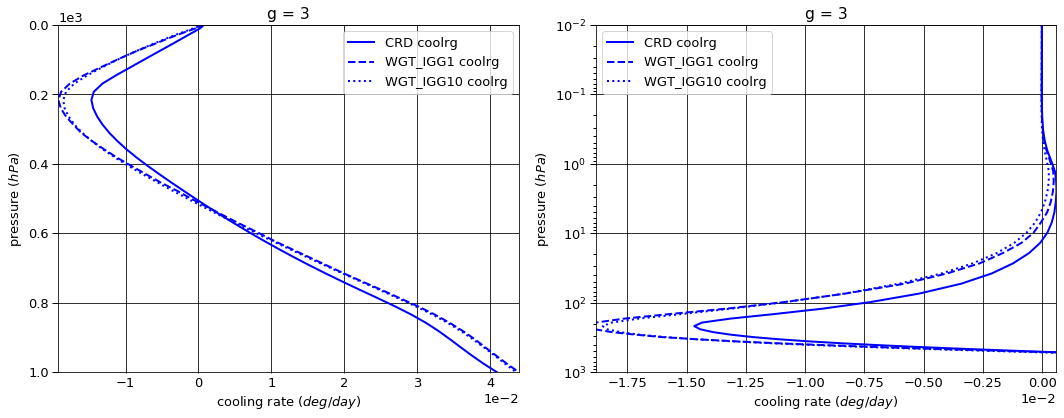

# Figure: cooling rate g-group 4

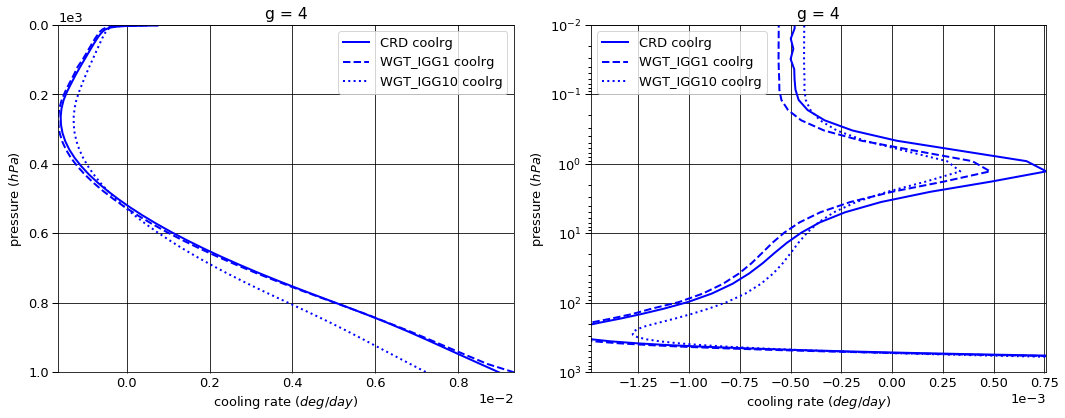

# Figure: cooling rate g-group total

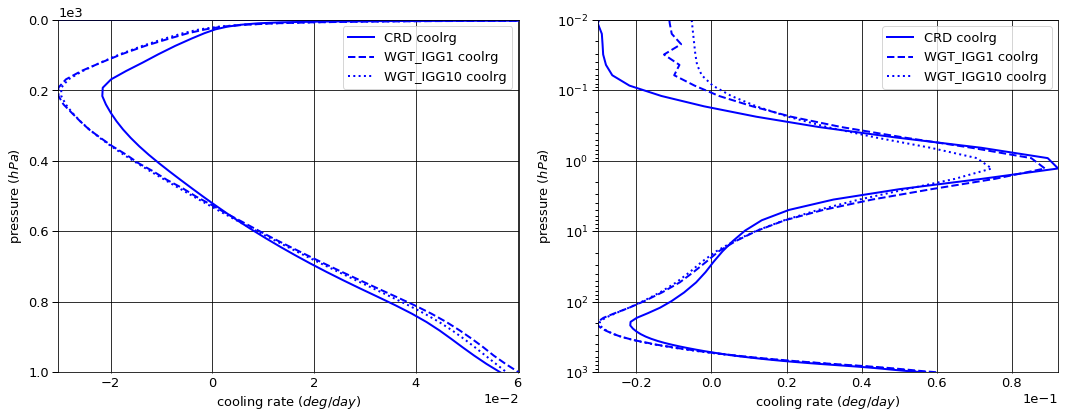

In [18]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [19]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.053459  0.000000  -0.053459
  1013.0   76     -0.136600  0.090908  -0.045691
2 0.0      1      -0.392146  0.000000  -0.392146
  1013.0   76     -0.976477  0.608034  -0.368443
3 0.0      1      -5.081797  0.000000  -5.081797
  1013.0   76     -7.075847  2.771088  -4.304758
4 0.0      1     -15.347478  0.000000 -15.347478
  1013.0   76    -15.566253  0.407930 -15.158323


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.037348  0.000000  -0.037348
  1013.0   76     -0.136600  0.103521  -0.033079
2 0.0      1      -0.241218  0.000000  -0.241218
  1013.0   76     -0.976477  0.639907  -0.336569
3 0.0      1      -4.864482  0.000000  -4.864482
  1013.0   76     -7.075847  2.944832  -4.131014
4 0.0      1     -15.350052  0.000000 -15.350052
  1013.0   76    -15.566253  0.400798 -15.165455


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.035661  0.000000  -0.035661
  1013.0   76     -0.136600  0.102668  -0.033932
2 0.0      1      -0.236894  0.000000  -0.236894
  1013.0   76     -0.976477  0.627840  -0.348637
3 0.0      1      -5.066629  0.000000  -5.066629
  1013.0   76     -7.075847  2.725318  -4.350528
4 0.0      1     -15.400373  0.000000 -15.400373
  1013.0   76    -15.566253  0.309373 -15.256880


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.016111  0.000000  0.016111
  1013.0   76     0.000000  0.012613  0.012613
2 0.0      1      0.150928  0.000000  0.150928
  1013.0   76     0.000000  0.031873  0.031873
3 0.0      1      0.217315  0.000000  0.217315
  1013.0   76     0.000000  0.173744  0.173744
4 0.0      1     -0.002574  0.000000 -0.002574
  1013.0   76     0.000000 -0.007132 -0.007132


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.017798  0.000000  0.017798
  1013.0   76     0.000000  0.011759  0.011759
2 0.0      1      0.155251  0.000000  0.155251
  1013.0   76     0.000000  0.019806  0.019806
3 0.0      1      0.015168  0.000000  0.015168
  1013.0   76     0.000000 -0.045770 -0.045770
4 0.0      1     -0.052895  0.000000 -0.052895
  1013.0   76     0.000000 -0.098557 -0.098557

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.031816
  1001.112500 75     0.000796
2 0.000312    1     -0.000665
  1001.112500 75     0.005826
3 0.000312    1     -0.000014
  1001.112500 75     0.040965
4 0.000312    1     -0.000479
  1001.112500 75     0.008981


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.013364
  1001.112500 75     0.000865
2 0.000312    1     -0.000062
  1001.112500 75     0.006002
3 0.000312    1     -0.000012
  1001.112500 75     0.043970
4 0.000312    1     -0.000554
  1001.112500 75     0.009343


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.006870
  1001.112500 75     0.000881
2 0.000312    1     -0.000080
  1001.112500 75     0.006126
3 0.000312    1     -0.000012
  1001.112500 75     0.043571
4 0.000312    1     -0.000429
  1001.112500 75     0.007229


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.018452
  1001.112500 75     0.000069
2 0.000312    1      0.000603
  1001.112500 75     0.000176
3 0.000312    1      0.000001
  1001.112500 75     0.003006
4 0.000312    1     -0.000076
  1001.112500 75     0.000362


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.024946
  1001.112500 75     0.000085
2 0.000312    1      0.000585
  1001.112500 75     0.000300
3 0.000312    1      0.000001
  1001.112500 75     0.002606
4 0.000312    1      0.000050
  1001.112500 75    -0.001751

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.874880,0.00000,-20.874880
1013.0,76,-23.755176,3.87796,-19.877215



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.493100,0.000000,-20.493100
1013.0,76,-23.755176,4.089059,-19.666117



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.739558,0.000000,-20.739558
1013.0,76,-23.755176,3.765198,-19.989977



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.38178,0.000000,0.381780
1013.0,76,0.00000,0.211098,0.211098



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.135322,0.000000,0.135322
1013.0,76,0.000000,-0.112762,-0.112762


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.032973
1001.112500,75,0.056567



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.013992
1001.112500,75,0.060181



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.007392
1001.112500,75,0.057807



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.018981
1001.112500,75,0.003614



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.025581
1001.112500,75,0.001240


In [20]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.005636,0.005770
2,0.040000,0.041342
3,0.290182,0.299459
4,0.664182,0.653430


In [21]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.539967e-19
2,5.006638e-21
3,2.220810e-20
4,2.164750e-26


In [22]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [23]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.539967e-19,NaN,0.005636,0.005770,0.005636,0.005770,1.0
2,5.006638e-21,9.037306e-03,0.040000,0.041342,0.045636,0.047111,1.0
3,2.220810e-20,4.435731e+00,0.290182,0.299459,0.335818,0.346570,500.0
4,2.164750e-26,9.747570e-07,0.664182,0.653430,1.000000,1.000000,500.0


In [24]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [25]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog         ratio        taulyr
layer g pressure                                                           
1     1 0.000312     9.191850e-18  7.996653e-19     11.494621  2.472486e-05
      2 0.000312     1.814352e-20  2.212162e-21      8.201713  4.987780e-08
      3 0.000312     3.684201e-23  3.591363e-23      1.025850  1.549325e-10
      4 0.000312     4.291726e-22  4.648425e-27  92326.454000  1.636702e-09
2     1 0.000750     9.192594e-18  8.018738e-19     11.463890  9.961113e-06
      2 0.000750     1.820647e-20  2.229041e-21      8.167847  2.016609e-08
      3 0.000750     3.729227e-23  3.635462e-23      1.025792  6.316847e-11
      4 0.000750     4.302116e-22  6.146244e-27  69995.850000  6.608382e-10
3     1 0.001052     9.194207e-18  8.064141e-19     11.401348  1.397599e-05
      2 0.001052     1.832586e-20  2.248679e-21      8.149612  2.847090e-08
      3 0.001052     3.794934e-23  3.699336e-23      1.025842  9.014610e-11
      4 0.001052     4.324409e-22  6.915731e-27  62530.028000  9.315524e-10
4     1 0.001476     9.195909e-18  8.112643e-19     11.335282  1.961674e-05
      2 0.001476     1.845631e-20  2.272556e-21      8.121387  4.023649e-08
      3 0.001476     3.870356e-23  3.772781e-23      1.025863  1.289779e-10
      4 0.001476     4.348428e-22  7.743561e-27  56155.408000  1.314127e-09
5     1 0.002070     9.197604e-18  8.161801e-19     11.269087  2.752824e-05
      2 0.002070     1.859259e-20  2.301234e-21      8.079401  5.687431e-08
      3 0.002070     3.954971e-23  3.855373e-23      1.025834  1.848592e-10
      4 0.002070     4.372911e-22  8.618357e-27  50739.496000  1.853555e-09
6     1 0.002904     9.199285e-18  8.211743e-19     11.202597  3.863476e-05
      2 0.002904     1.873627e-20  2.336456e-21      8.019099  8.044236e-08
      3 0.002904     4.052085e-23  3.950416e-23      1.025736  2.656837e-10
      4 0.002904     4.397845e-22  9.526828e-27  46162.746000  2.614877e-09
7     1 0.004074     9.200946e-18  8.262715e-19     11.135499  5.422394e-05
      2 0.004074     1.888969e-20  2.380540e-21      7.935042  1.138589e-07
      3 0.004074     4.166404e-23  4.062615e-23      1.025547  3.832295e-10
      4 0.004074     4.423242e-22  1.046518e-26  42266.283000  3.689264e-09
8     1 0.005714     9.202578e-18  8.315058e-19     11.067365  7.609879e-05
      2 0.005714     1.905610e-20  2.436478e-21      7.821167  1.612964e-07
      3 0.005714     4.304525e-23  4.198561e-23      1.025238  5.554181e-10
      4 0.005714     4.449116e-22  1.143912e-26  38893.845000  5.205128e-09
9     1 0.008015     9.204169e-18  8.369259e-19     10.997592  1.068018e-04
      2 0.008015     1.924012e-20  2.508036e-21      7.671389  2.287880e-07
      3 0.008015     4.475708e-23  4.367502e-23      1.024775  8.101841e-10
      4 0.008015     4.475488e-22  1.245703e-26  35927.407000  7.344591e-09
10    1 0.011243     9.205702e-18  8.425975e-19     10.925385  1.498919e-04
      2 0.011243     1.944812e-20  2.599796e-21      7.480632  3.250504e-07
      3 0.011243     4.692920e-23  4.582383e-23      1.024122  1.191818e-09
      4 0.011243     4.502377e-22  1.352355e-26  33292.868000  1.036412e-08
11    1 0.015771     9.207152e-18  8.486125e-19     10.849654  2.103735e-04
      2 0.015771     1.968905e-20  2.717149e-21      7.246215  4.628241e-07
      3 0.015771     4.974351e-23  4.861357e-23      1.023243  1.772488e-09
      4 0.015771     4.529808e-22  1.463767e-26  30946.234000  1.462650e-08
12    1 0.022122     9.208483e-18  8.551007e-19     10.768887  2.952635e-04
      2 0.022122     1.997553e-20  2.866261e-21      6.969195  6.608594e-07
      3 0.022122     5.345565e-23  5.229907e-23      1.022115  2.672695e-09
      4 0.022122     4.557829e-22  1.579475e-26  28856.600000  2.064364e-08
13    1 0.031031     9.209648e-18  8.622412e-19     10.681058  4.144209e-04
      2 0.031031     2.032526e-20  3.054095e-21      6.655083  9.471126e-07
      3 0.031031     5.842431e-23  5.723742e-23      1.020736  4.099129e-0

# Histogram of wavenumbers in g-group 1

In [26]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
